In [1]:
import kagglehub
import torch
from pandas import read_csv, concat
import matplotlib.pyplot as plt
# import numpy as np

In [2]:
# Import the Dataset from kaggle and load on a Tensor
Nist_dataset = kagglehub.dataset_download("sachinpatel21/az-handwritten-alphabets-in-csv-format")

chunksize = 250

# the list that contains all the dataframes
list_of_dataframes = []

for df in read_csv(Nist_dataset+"/A_Z Handwritten Data.csv", chunksize=chunksize):
    # process your data frame here
    # then add the current data frame into the list
    list_of_dataframes.append(df)

# if you want all the dataframes together, here it is
handwritten_alphabet = concat(list_of_dataframes)



# handwritten_alphabet = read_csv(Nist_dataset+"/A_Z Handwritten Data.csv")
# print(handwritten_alphabet)
handwritten_alphabet = torch.Tensor(handwritten_alphabet.values).cuda()

In [ ]:
from string import ascii_uppercase

# Crear una lista de letras del abecedario
letras = list(ascii_uppercase)  # Para mayúsculas, usa ascii_uppercase; para minúsculas, usa ascii_lowercase

# Crear el diccionario
alphabet_dictionary = {i: letras[i] for i in range(26)}

In [4]:
# Split The data on Images and Labels
# handwritten_alphabet[:,0]
handwritten_alphabet_classes = handwritten_alphabet[:,0].long()
handwritten_alphabet_images = handwritten_alphabet[:,1:].reshape((-1,28,28))

In [5]:
#Create a Dataset Class to load the Images and labels
class image_dataset(torch.utils.data.Dataset):
    def __init__(self,images:torch.Tensor,labels:torch.Tensor):
        if len(images[:]) != len(labels):
            raise IndexError("The size must be the same")
        self.images = images
        self.labels = labels

    def __getitem__(self, index):
        
        image = self.images[None,index]
        label = self.labels[index]

        if type(index) == list:
            image = image.swapaxes(0,1)

        return image, label
    
    def __len__(self):
        return len(self.labels)

In [6]:
# Create and Split the dataset on Train, Validation and Test Datasets
image_dataset = image_dataset(handwritten_alphabet_images,handwritten_alphabet_classes)

train,val,test = torch.utils.data.random_split(image_dataset,[0.8,0.1,0.1])


In [7]:
from torch import nn

class ConvNet(nn.Module):
    
    def __init__(self,kernel_size:int,number_of_clases:int):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=kernel_size),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,kernel_size=kernel_size),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64,128,kernel_size=kernel_size),
            nn.ReLU(),
            nn.Flatten()
        )
        self.classifiyer = nn.Sequential(
            nn.Linear(128*kernel_size*kernel_size,110),
            nn.ReLU(),
            nn.Linear(110,number_of_clases),
            nn.Softmax(1)
        )

    def forward(self,x):
        x = self.encoder(x)
        x = self.classifiyer(x)

        return x

In [ ]:
Conv_Clasifier = ConvNet(kernel_size=3,number_of_clases=26).cuda()

# from torchsummary import summary
# summary(Conv_Clasifier,(1,28,28),batch_size=2)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [2, 32, 26, 26]             320
              ReLU-2            [2, 32, 26, 26]               0
         MaxPool2d-3            [2, 32, 13, 13]               0
            Conv2d-4            [2, 64, 11, 11]          18,496
              ReLU-5            [2, 64, 11, 11]               0
         MaxPool2d-6              [2, 64, 5, 5]               0
            Conv2d-7             [2, 128, 3, 3]          73,856
              ReLU-8             [2, 128, 3, 3]               0
           Flatten-9                  [2, 1152]               0
           Linear-10                   [2, 110]         126,830
             ReLU-11                   [2, 110]               0
           Linear-12                    [2, 26]           2,886
          Softmax-13                    [2, 26]               0
Total params: 222,388
Trainable params:

Categoría predicha: U
Categoría real: G


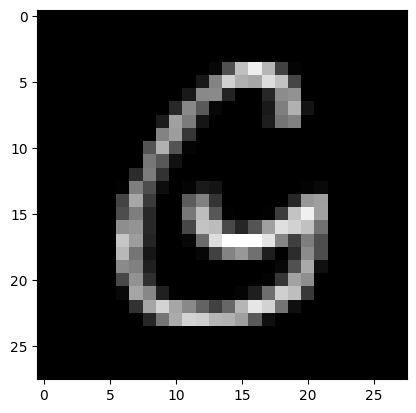

In [16]:
#Try untrained net
img,lbl = train[torch.randint(0,len(train),size=(1,))]

img = img[None,:]

logits = Conv_Clasifier(img.cuda())
print("Categoría predicha:",alphabet_dictionary[logits.argmax().item()])
print("Categoría real:",alphabet_dictionary[lbl.item()])
plt.imshow(img.cpu().squeeze(),cmap="grey");


In [96]:
imgs = train[0:2][0].cuda()
logits = Conv_Clasifier(imgs)


In [97]:
logits.shape

torch.Size([2, 26])

In [17]:
from torch.utils.data import DataLoader
batch_size=250
train_loader = DataLoader(
    dataset=train,
    shuffle=True,
    batch_size=batch_size
)
imgs_batch, lbls_batch = next(iter(train_loader))

val_loader = DataLoader(
    dataset=val,
    shuffle=True,
    batch_size=batch_size
)

In [18]:
epochs = 30
learning_rate = 0.01

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(Conv_Clasifier.parameters(), lr=learning_rate)

In [20]:
def train_loop(loader:torch.utils.data.DataLoader, model : nn.Module, optimizer:torch.optim, loss_fn:callable):
    nlotes = len(loader)
    train_size = len(loader.dataset)

    model.train()   #Preparo el modelo para el entrenamiento

    train_losses, train_accuracy = 0,0

    for nlote,(x,y) in enumerate(loader):
        x,y = x.cuda(), y.cuda()

        # Forward Pass
        logits = model(x)

        # Backpropagation
        loss = loss_fn(logits,y)    #Calculo de loss
        loss.backward()             #Calculo de gradiente
        optimizer.step()            #Actualización de parámetros
        optimizer.zero_grad()       #Limpieza del optimizador

        #Guardamos algunas caractgerísticas para plotear al final
        train_losses += loss.item()
        train_accuracy += (logits.argmax(1)==y).type(torch.float).sum().item()

        #Muestra del proceso
        if nlote % 10 == 0:
            print("Nº de lote: ",nlote)
            print("Loss: ",loss.item())

    train_losses /= nlotes
    train_accuracy /= train_size
    
    print()
    print("\tAccuracy/Loss Promedio")
    print(f"\t\tEntrenamiento: {(100*train_accuracy):>0.1f}% / {train_losses:>8f}")

In [21]:
def val_loop(loader:torch.utils.data.DataLoader, model:nn.Module, loss_fn:callable):
    
    val_size = len(loader.dataset)
    nlotes = len(loader)

    model.eval()         #Preparo el modelo para inferencia

    val_losses, val_accuracy = 0,0

    with torch.no_grad():       #Calcelo el calculo del gradiente
        for x,y in loader:
            
            x,y = x.cuda(), y.cuda()

            logits = model(x)       # Inferencia
            
            val_losses += loss_fn(logits,y.long()).item()
            val_accuracy += (logits.argmax(1)==y).type(torch.float).sum().item()

    val_losses /= nlotes
    val_accuracy /= val_size

    print(f"\t\tValidación: {(100*val_accuracy):>0.1f}% / {val_losses:>8f}")



In [23]:
for epoch in range(epochs):
    print(f"Itenración: {(epoch + 1)} / {epochs} -----------------------------")
    
    #Train
    train_loop(train_loader,Conv_Clasifier,optimizer,loss)

    #Validation
    val_loop(val_loader,Conv_Clasifier,loss)

print("Finalizado entrenamiento del modelo!")

Itenración: 1 / 30 -----------------------------
Nº de lote:  0
Loss:  2.5698888301849365
Nº de lote:  10
Loss:  2.5762691497802734
Nº de lote:  20
Loss:  2.541379451751709
Nº de lote:  30
Loss:  2.572666645050049
Nº de lote:  40
Loss:  2.630079984664917
Nº de lote:  50
Loss:  2.5703012943267822
Nº de lote:  60
Loss:  2.5814342498779297
Nº de lote:  70
Loss:  2.582347869873047
Nº de lote:  80
Loss:  2.5984597206115723
Nº de lote:  90
Loss:  2.5921835899353027
Nº de lote:  100
Loss:  2.542448043823242
Nº de lote:  110
Loss:  2.5575151443481445
Nº de lote:  120
Loss:  2.5601139068603516
Nº de lote:  130
Loss:  2.6315066814422607
Nº de lote:  140
Loss:  2.5729403495788574
Nº de lote:  150
Loss:  2.5965704917907715
Nº de lote:  160
Loss:  2.5706305503845215
Nº de lote:  170
Loss:  2.5803310871124268
Nº de lote:  180
Loss:  2.552852153778076
Nº de lote:  190
Loss:  2.5610129833221436
Nº de lote:  200
Loss:  2.5538978576660156
Nº de lote:  210
Loss:  2.582577705383301
Nº de lote:  220
Loss: 

Clase real:  U
Clase Predicha:  U


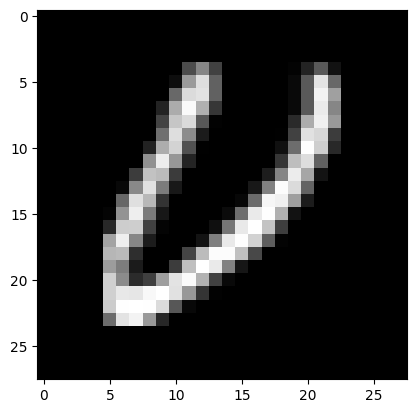

In [52]:
img,lbl = val[torch.randint(0,len(val),size=(1,))]

img = img[None,:].cuda()

logits = Conv_Clasifier(img)
lbl_predict = logits.argmax().item()
print("Clase real: ",alphabet_dictionary[lbl.item()])
print("Clase Predicha: ",alphabet_dictionary[lbl_predict])

plt.imshow(img.cpu().squeeze(),cmap="grey");

In [53]:
val_loop(val_loader,Conv_Clasifier,loss)

		Validación: 84.8% / 2.473210
